/tmp/ipython-input-243238282.py:20: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_r = psnr(img[..., 0], compressed[..., 0])
/tmp/ipython-input-243238282.py:21: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_g = psnr(img[..., 1], compressed[..., 1])
/tmp/ipython-input-243238282.py:22: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_b = psnr(img[..., 2], compressed[..., 2])


Iteration 1, Best q = 0.500000, Loss = 242.6455
Iteration 2, Best q = 0.500000, Loss = 242.6455
Iteration 3, Best q = 0.500000, Loss = 242.6455
Iteration 4, Best q = 0.500000, Loss = 242.6455
Iteration 5, Best q = 0.500000, Loss = 242.6455
Iteration 6, Best q = 0.500000, Loss = 242.6455
Iteration 7, Best q = 0.500000, Loss = 242.6455
Iteration 8, Best q = 0.500000, Loss = 242.6455
Iteration 9, Best q = 0.500000, Loss = 242.6455
Iteration 10, Best q = 0.500000, Loss = 242.6455
Iteration 11, Best q = 0.500000, Loss = 242.6455
Iteration 12, Best q = 0.500000, Loss = 242.6455
Iteration 13, Best q = 0.500000, Loss = 242.6455
Iteration 14, Best q = 0.500000, Loss = 242.6455
Iteration 15, Best q = 0.500000, Loss = 242.6455
Iteration 16, Best q = 0.500000, Loss = 242.6455
Iteration 17, Best q = 0.500000, Loss = 242.6455
Iteration 18, Best q = 0.500000, Loss = 242.6455
Iteration 19, Best q = 0.500000, Loss = 242.6455
Iteration 20, Best q = 0.500000, Loss = 242.6455
Iteration 21, Best q = 0.5000

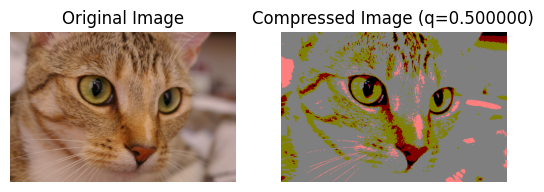

In [ ]:
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage import data
import random
import matplotlib.pyplot as plt


img = data.chelsea().astype(np.float32) / 255.0


def quantize(image, q):
    q = max(q, 1e-6)
    return np.round(image / q) * q


def objective(q):
    q = max(1e-6, q)
    compressed = quantize(img, q)

    psnr_r = psnr(img[..., 0], compressed[..., 0])
    psnr_g = psnr(img[..., 1], compressed[..., 1])
    psnr_b = psnr(img[..., 2], compressed[..., 2])
    quality = (psnr_r + psnr_g + psnr_b) / 3.0
    bpp = 8 / q
    loss = (100 - quality) + bpp * 10
    return loss


num_particles = 30
num_iterations = 50
w = 0.5
c1 = 1.5
c2 = 1.5

particles = np.random.uniform(1e-6, 0.5, size=num_particles)
velocities = np.zeros(num_particles)

pbest = particles.copy()
pbest_scores = np.array([objective(p) for p in particles])
gbest_idx = np.argmin(pbest_scores)
gbest = pbest[gbest_idx]
gbest_score = pbest_scores[gbest_idx]

for iter in range(num_iterations):
    for i in range(num_particles):
        r1, r2 = random.random(), random.random()
        velocities[i] = (w * velocities[i] +
                         c1 * r1 * (pbest[i] - particles[i]) +
                         c2 * r2 * (gbest - particles[i]))
        particles[i] += velocities[i]

        particles[i] = np.clip(particles[i], 1e-6, 0.5)

        score = objective(particles[i])

        if score < pbest_scores[i]:
            pbest[i] = particles[i]
            pbest_scores[i] = score

    gbest_idx = np.argmin(pbest_scores)
    if pbest_scores[gbest_idx] < gbest_score:
        gbest = pbest[gbest_idx]
        gbest_score = pbest_scores[gbest_idx]

    print(f"Iteration {iter+1}, Best q = {gbest:.6f}, Loss = {gbest_score:.4f}")

print(f"\nOptimal quantization step size q: {gbest}")

compressed_img = quantize(img, gbest)

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f'Compressed Image (q={gbest:.6f})')
plt.imshow(compressed_img)
plt.axis('off')

plt.show()
